# ELLIPSE cohesion analyses

Find optimal hyperparameters on the ELLIPSE dataset using ModernBERT for the cohesion scores only

In [ ]:
# in case some libraries are missing

!pip install transformers
!pip install wandb
!pip install datasets

!pip uninstall -y pyarrow apache-arrow
!pip install --no-cache-dir --force-reinstall "pyarrow==16.1.0"
!pip install --upgrade --no-cache-dir "datasets"

!pip install --no-cache-dir --force-reinstall "numpy==2.1.3" "pandas==2.2.2"
!pip install --no-cache-dir --force-reinstall "numpy==1.26.4" "pandas==2.1.4"
!pip install transformers[torch]
!pip install 'accelerate>=0.26.0'

In [6]:
# if you are having some memory issues, clean up cache (but, really, probably need to reduce batch size)

import torch
import gc

# Clear cache
torch.cuda.empty_cache()
gc.collect()

# Check memory usage
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# Expandable segments: Allows PyTorch to dynamically resize memory segments instead of using fixed sizes
# Reduces fragmentation: More flexible memory management prevents unusable fragmented memory
# Better memory utilization: Can squeeze more out of available GPU memory

Allocated: 0.00 GB
Reserved: 0.00 GB


In [7]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from scipy import stats
from IPython.display import display
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    DefaultDataCollator,
)
import wandb  # Weights and Biase
from datasets import load_dataset, Dataset, DatasetDict

import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Jupyter notebooks can fork processes for various operations
# Tokenizers use Rust-based parallelism that doesn't play well with forking
# Setting TOKENIZERS_PARALLELISM=false disables the parallel processing to avoid deadlocks

import torch

torch.set_float32_matmul_precision("high")
# TF32: Uses 19-bit precision instead of 32-bit for matrix operations
# Benefit: ~1.5-2x speedup on compatible GPUs (A100, RTX 30xx/40xx series)
# Trade-off: Slightly reduced numerical precision (usually negligible for ML training)

model_id = "answerdotai/ModernBERT-large"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Replace the variables below with your own: name, project name, and project directory
%env WANDB_PROJECT = ellipse
%env WANDB_DIR = bin
%env WANDB_NOTEBOOK_NAME = ellipse_llm_modeling_modernbert.ipynb

/home/jovyan/conda_envs/wesenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


env: WANDB_PROJECT=ellipse
env: WANDB_DIR=bin
env: WANDB_NOTEBOOK_NAME=ellipse_llm_modeling_modernbert.ipynb


## Configure Logging

In [8]:
from transformers import logging

logging.set_verbosity_error()
%env WANDB_SILENT = true

env: WANDB_SILENT=true


In [9]:
# There is a problem with the DF. It is not in UTF-8

#!pip install charset-normalizer

from charset_normalizer import from_path

result = from_path("data/ellipse_corpus_w_splits_prompts.csv").best()
print(result.encoding)  # it is cp1252 encoding (whatever that is)

mac_iceland


In [10]:
# Read using the detected encoding and save as UTF-8:
enc = result.encoding

df = pd.read_csv("data/ellipse_corpus_w_splits_prompts.csv", encoding=enc)

df.to_csv(
    "data/ellipse_corpus_w_splits_prompts_utf8.csv", index=False, encoding="utf-8"
)

## Load and Prepare ASAP Corpus

In [11]:
# load it
ellipse_df = pd.read_csv("data/ellipse_corpus_w_splits_prompts_utf8.csv")

# set up text so it includes assignment
ellipse_df["text"] = (
    ellipse_df["full_text"] + tokenizer.sep_token + ellipse_df["assignment"]
)

In [12]:
# what is in there?
# ellipse_df.sample(2)

with pd.option_context("display.max_colwidth", None):
    print(ellipse_df["text"].sample(2))

5837                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      March 2020/10\n\nGeneric_Name\n\nMs. Generic_N

In [13]:
ellipse_df_clean = (
    ellipse_df[["text", "Cohesion", "split"]]
    .rename(
        columns={
            "full_text": "text",
            "Cohesion": "label",
        }
    )
    .assign(label=lambda df: df.label.astype("float"))
    .reset_index(drop=True)
)

ellipse_df_clean.sample(2)

,text,label,split
301,High school the place where we can all do anyt...,3.5,testing
902,The option of distance learning can be helpful...,3.0,training


## Simple word count

In [14]:
ellipse_df_clean.text.str.split().str.len().describe()

count    6482.000000
mean      480.906510
std       192.322249
min        80.000000
25%       342.000000
50%       451.000000
75%       578.000000
max      1323.000000
Name: text, dtype: float64

## Check for missing data

In [15]:
print(ellipse_df_clean.info())
ellipse_df_clean = ellipse_df_clean.dropna(how="any")
print(ellipse_df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6482 entries, 0 to 6481
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    6482 non-null   object 
 1   label   6482 non-null   float64
 2   split   6482 non-null   object 
dtypes: float64(1), object(2)
memory usage: 152.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6482 entries, 0 to 6481
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    6482 non-null   object 
 1   label   6482 non-null   float64
 2   split   6482 non-null   object 
dtypes: float64(1), object(2)
memory usage: 152.1+ KB
None


### Get training and test sets

These are already defined in the datasets. Just need to divide and name them

This is with a validation set used for hyperparameters

Training and test sets would be different and found underset.



In [16]:
# What's in there?

sets = ellipse_df_clean["split"].unique()
print(sets)

['testing' 'training' 'validation']


In [17]:
ellipse_dd = DatasetDict(
    {
        "train": Dataset.from_pandas(
            ellipse_df_clean[ellipse_df_clean["split"] == "training"].reset_index(
                drop=True
            )
        ),
        # Use a subsample to validate the notebook:
        # "train": Dataset.from_pandas(
        #     asap_df_clean[asap_df_clean["pubpriv"] == "0"]
        #     .reset_index(drop=True)
        #     .sample(200)
        # ),
        "dev": Dataset.from_pandas(
            ellipse_df_clean[ellipse_df_clean["split"] == "validation"].reset_index(
                drop=True
            )
        ),
        "test": Dataset.from_pandas(
            ellipse_df_clean[ellipse_df_clean["split"] == "testing"].reset_index(
                drop=True
            )
        ),
    }
)
ellipse_dd

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'split'],
        num_rows: 3732
    })
    dev: Dataset({
        features: ['text', 'label', 'split'],
        num_rows: 829
    })
    test: Dataset({
        features: ['text', 'label', 'split'],
        num_rows: 1921
    })
})

In [18]:
# anything strange in here (text length)

# what columns are available
print("Columns:", ellipse_dd["train"].column_names)

text_column = "text"


# function for counting words
def count_words(text):
    return {"word_count": len(text[text_column].split())}


# add word counts to splits
ellipse_dd_with_counts = ellipse_dd.map(count_words)

# stats
for split_name in ["train", "dev", "test"]:
    split_data = ellipse_dd_with_counts[split_name]
    word_counts = split_data["word_count"]

    print(f"\n{split_name.upper()}")
    print(f"Total samples: {len(word_counts)}")
    print(f"Min words: {min(word_counts)}")
    print(f"Max words: {max(word_counts)}")
    print(f"SD: {np.std(word_counts)}")
    print(f"Mean words: {sum(word_counts) / len(word_counts)}")
    print(
        f"Examples over 1000 words: {sum(1 for count in word_counts if count > 1000)}"
    )
    print(
        f"Percentage over 1000 words: {sum(1 for count in word_counts if count > 1000) / len(word_counts) * 100}"
    )

Columns: ['text', 'label', 'split']


Map: 100%|██████████| 1921/1921 [00:00<00:00, 7388.83 examples/s]



TRAIN
Total samples: 3732
Min words: 80
Max words: 1323
SD: 190.63480608213652
Mean words: 478.54769560557344
Examples over 1000 words: 88
Percentage over 1000 words: 2.3579849946409435

DEV
Total samples: 829
Min words: 114
Max words: 1296
SD: 200.16114678667518
Mean words: 482.39324487334136
Examples over 1000 words: 23
Percentage over 1000 words: 2.7744270205066344

TEST
Total samples: 1921
Min words: 88
Max words: 1310
SD: 192.0130736784169
Mean words: 484.8474752732952
Examples over 1000 words: 44
Percentage over 1000 words: 2.290473711608537


### Pre-process inputs (tokenization)


In [19]:
# get tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [20]:
# tokenization function


def tokenize_inputs(example):
    return tokenizer(example["text"])

In [21]:
# tokenize text

ellipse_dd_tokenized = ellipse_dd.map(
    tokenize_inputs, batched=True, remove_columns=["text"]
)

Map: 100%|██████████| 1921/1921 [00:05<00:00, 344.47 examples/s]


In [22]:
ellipse_dd_tokenized["train"]

Dataset({
    features: ['label', 'split', 'input_ids', 'attention_mask'],
    num_rows: 3732
})

### Data Collator
A data collator feeds the data to the language model. [More information](https://huggingface.co/course/chapter3/2?fw=pt).




In [23]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [24]:
def model_init(config):
    return AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=1,  # Regression
        # pooler_dropout=config.pooler_dropout
    )

### Define Metrics

In [25]:
# This code is returning NAs, so see code belpow

# def compute_metrics(eval_pred):
#    logits, labels = eval_pred
#    return {"mse": mean_squared_error(logits, labels)}

In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # convert to numpy arrays and flatten
    logits = np.array(logits).flatten()
    labels = np.array(labels).flatten()

    # remove NaN values if they pop up
    mask = ~(np.isnan(logits) | np.isnan(labels))
    logits_clean = logits[mask]
    labels_clean = labels[mask]

    # Return NaN if no valid values, otherwise compute MSE
    if len(logits_clean) == 0:
        return {"mse": float("nan")}

    return {"mse": mean_squared_error(labels_clean, logits_clean)}

### Hyperparameter Optimization

Config is based on hyperparameters used in benchmark tasks in Warner et al. (2024):
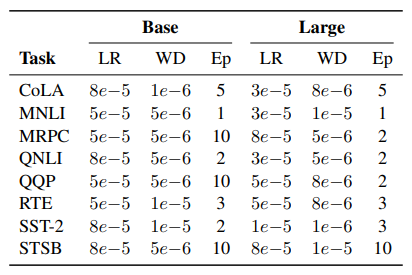

In [27]:
sweep_config = {
    "name": "modernbert-large",
    "method": "bayes",  # bayes
    "run_cap": 42,  # bayesian optimizer will run until stopped if this is not set
    "metric": {
        "name": f"eval/mse",  # mean squared error
        "goal": "minimize",
    },  # we want to "minimize" the mean squared error.
    "parameters": {
        "batch_size": {
            "value": 4
        },  # We will use the recommended batch size of 12 (this may be too large for memomry though)
        "gradient_accumulation_steps": {"value": 3},
        # Gradient accumulation accumulates gradients over 3 steps before updating weights, simulating a larger batch size (12 because batch size is 4)
        "learning_rate": {"values": [1e-5, 3e-5, 5e-5, 8e-5]},
        "num_train_epochs": {"values": [1, 2, 3, 5, 10]},
        # 'pooler_dropout': {'values': [0, 0.15, 0.30]}, #Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of the input units to 0 during training
        "weight_decay": {
            "values": [1e-6, 5e-6, 8e-6, 1e-5]
        },  # hyperparameter that controls the L2 regularization applied to the model's weights during training. L2 regularization is a common technique used to prevent overfitting by adding a penalty term to the loss function, proportional to the square of the model's weights
    },
}

In [28]:
def train():
    with wandb.init():
        # set sweep configuration
        config = wandb.config

        # Customize the trainer
        training_args = TrainingArguments(
            output_dir="bin",
            optim="adamw_torch",  # Specify your optimizer
            logging_dir="logs",
            load_best_model_at_end=False,  # Do not load the best model at the end
            metric_for_best_model="mse",  # We will be using mean squared error to evaluate model performance
            eval_strategy="epoch",  # Changed from evaluation_strategy # Evaluate model performance at the end of each epoch
            save_strategy="no",  # checkpoints are saved after each epoch
            greater_is_better=False,  # mse likes lower
            log_level="error",  # only error-level messages will be logged
            disable_tqdm=False,  # show progress bar
            report_to="wandb",
            # The hyper parameters we are tuning (number of epochs, learning rate, and batch size)
            # are called in from the configuration dictionary
            num_train_epochs=config.num_train_epochs,
            learning_rate=config.learning_rate,
            per_device_train_batch_size=config.batch_size,
            per_device_eval_batch_size=16,
        )

        model = model_init(config)

        # Initialize the trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=ellipse_dd_tokenized["train"],
            eval_dataset=ellipse_dd_tokenized["dev"],
            compute_metrics=compute_metrics,
            # tokenizer=tokenizer, # this is deprecated
            processing_class=tokenizer,
        )

        # Start training loop
        trainer.train()

In [29]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, train)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ellipse_llm_modeling_modernbert.ipynb.


Create sweep with ID: xmnp0bvw
Sweep URL: https://wandb.ai/ai-aloe/ellipse/sweeps/xmnp0bvw


Traceback (most recent call last):
  File "/tmp/ipykernel_324/3995307531.py", line 42, in train
    trainer.train()
    ~~~~~~~~~~~~~^^
  File "/home/jovyan/conda_envs/wesenv/lib/python3.13/site-packages/transformers/trainer.py", line 2328, in train
    return inner_training_loop(
        args=args,
    ...<2 lines>...
        ignore_keys_for_eval=ignore_keys_for_eval,
    )
  File "/home/jovyan/conda_envs/wesenv/lib/python3.13/site-packages/transformers/trainer.py", line 2753, in _inner_training_loop
    self.control = self.callback_handler.on_step_end(args, self.state, self.control)
                   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/wesenv/lib/python3.13/site-packages/transformers/trainer_callback.py", line 534, in on_step_end
    return self.call_event("on_step_end", args, state, control)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/wesenv/lib/python3.13/site-packages

In [30]:
print("hello")

hello
